In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
from scipy.optimize import minimize, least_squares

# Load test samples
from aeons.tools import pickle_in
samples_g_1, samples_c_1, samples_w_1 = pickle_in("../test_samples/samples_1.pickle")

from aeons.covariance import logX_mu, logX_Sigmainv, points_at_iteration, X_mu, X_Sigma, X_Sigmainv, data_at_iteration
from aeons.true_distribution import generate_Xs
from aeons.lm_partial import analytic_lm_params
from aeons.bayes import logPr_bayes, logPr_laplace, logPr_gaussian, minimise_ls, minimise_bayes, minimise_gaussian
from aeons.likelihoods import likelihood, linear_like, quad_like, log_like, simple_like, middle_like, full_like
linear, quad, log = linear_like(), quad_like(), log_like()
simple, middle, full = simple_like(), middle_like(), full_like()
simple_log, middle_log, full_log = simple_like(logX=True), middle_like(logX=True), full_like(logX=True)
from aeons.hessian import hess_autograd

In [286]:
def nk_dead(nlive, ndead):
    return nlive * np.ones(ndead)

def nk_dead_live(nlive, ndead):
    nk0 = nlive * np.ones(ndead)
    nk1 = np.flip(np.arange(1, nlive))
    return np.concatenate((nk0, nk1))

def nk_live(nlive):
    return np.flip(np.arange(1, nlive + 1))

In [279]:
def sigma_est(y, likelihood, mean_X, theta):
    N = len(y)
    loss = mean_X - likelihood.inverse(y, theta)
    return np.sqrt(np.sum(loss**2)/N)

def logPr_ls(y, likelihood, mean_X, theta, sigma):
    N = len(y)
    loss = mean_X - likelihood.inverse(y, theta)
    L_sq = np.sum(loss**2)
    prefactor = -1/2 * N * np.log(2*np.pi*sigma**2)
    return prefactor - L_sq/(2*sigma**2)

def hess_ls_sigma(y, likelihood, mean_X, theta_max, sigma):
    N = len(y)
    y = torch.from_numpy(y)
    mean_X = torch.from_numpy(mean_X)
    theta_sigma_max = torch.tensor([*theta_max, sigma], requires_grad=True)
    def func(theta_sigma):
        if len(theta_sigma) == 2:
            theta, sigma = theta_sigma
        else:
            *theta, sigma = theta_sigma
        loss = mean_X - likelihood.inverse(y, theta)
        L_sq = torch.sum(loss**2)
        prefactor = -1/2 * N * torch.log(2*torch.pi*sigma**2)
        return prefactor - L_sq/(2*sigma**2)
    from torch.autograd.functional import hessian
    H = hessian(func, theta_sigma_max)
    return np.array(H)

def logZ(logPmax, H, D):
    print(logPmax, - 1/2 * np.log(abs(np.linalg.det(H))))
    return logPmax - 1/2 * np.log(abs(np.linalg.det(H))) + D/2 * np.log(2*np.pi)

def logZ_ls(y, likelihood, mean_X, theta_max):
    sigma_l = sigma_est(y, likelihood, mean_X, theta_max)
    logPmax = logPr_ls(y, likelihood, mean_X, theta_max, sigma_l)
    H = hess_ls_sigma(y, likelihood, mean_X, theta_max, sigma_l)
    return logZ(logPmax, H, D=len(theta_max)+1)

In [295]:
def logPr_bayes_full(y, likelihood, mean, covinv, theta, prefactor):
    Xstar = likelihood.inverse(y, theta)
    log_abs_fprimes = np.log(abs(likelihood.prime(Xstar, theta)))
    return prefactor - np.sum(log_abs_fprimes) - 1/2 * (Xstar - mean).T @ covinv @ (Xstar - mean)

def hess_bayes(y, likelihood, mean, covinv, theta_max):
    y = torch.from_numpy(y)
    mean = torch.from_numpy(mean)
    covinv = torch.from_numpy(covinv)
    theta_max = torch.tensor(theta_max, requires_grad=True)
    def func(theta):
        Xstar = likelihood.inverse(y, theta)
        log_abs_fprimes = torch.log(abs(likelihood.prime(Xstar, theta)))
        return - torch.sum(log_abs_fprimes) - 1/2 * (Xstar - mean).T @ covinv @ (Xstar - mean)
    from torch.autograd.functional import hessian
    H = hessian(func, theta_max)
    return np.array(H)

def logZ_bayes(y, likelihood, mean, covinv, theta_max, prefactor):
    logPmax = logPr_bayes_full(y, likelihood, mean, covinv, theta_max, prefactor)
    H = hess_bayes(y, likelihood, mean, covinv, theta_max)
    return logZ(logPmax, H, D=len(theta_max))

In [366]:
points = 500
nk = 500 * np.ones(points)
mean_X = X_mu(nk)
covinv_X = X_Sigmainv(nk)
eigvals_b = np.linalg.eigvals(covinv_X)
prefactor_b = 1/2 * np.log(eigvals_b).sum()

theta_true = np.array([10])

In [367]:
X = generate_Xs(nk)
y = simple.func(X, theta_true)
theta_l = minimise_ls(y, simple, mean_X, theta_true).x
sigma_l = sigma_est(y, simple, mean_X, theta_l)
theta_b = minimise_bayes(y, simple, mean_X, covinv_X, theta_true).x
logZ_l = logZ_ls(y, simple, mean_X, theta_l)
logZ_b = logZ_bayes(y, simple, mean_X, covinv_X, theta_b, prefactor_b)
theta_l, theta_b

1554.949182270367 -11.989975184990945
3777.6212725036735 -0.9352334997423497


(array([10.79488354]), array([11.17913818]))

In [282]:
logsigmas_b = - 0.5 * np.log(eigvals_b)
np.log(sigma_l), logsigmas_b.mean()

(-4.705975799416152, -6.716606765080862)

In [283]:
prefactor_l = - np.log(sigma_l) * points
prefactor_l, prefactor_b

(2352.9878997080764, 3358.3033825404314)

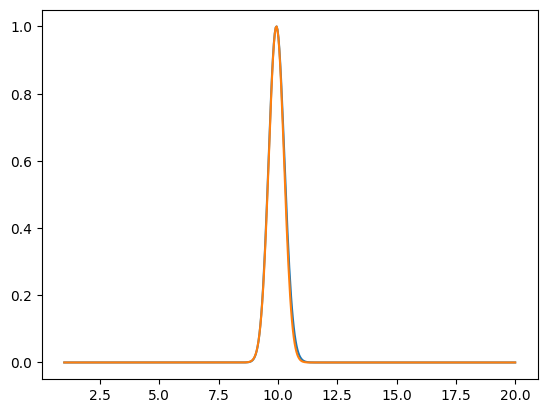

In [285]:
theta_b = minimise_bayes(y, simple, mean_X, covinv_X, theta_true).x
logPmax_b = logPr_bayes_full(y, simple, mean_X, covinv_X, theta_b, prefactor_b)
H_b = hess_bayes(y, simple, mean_X, covinv_X, theta_l)
ds = np.linspace(1, 20, 500)
logprs_b = np.zeros_like(ds)
logprs_bl = np.zeros_like(ds)
for i, d in enumerate(ds):
    logprs_b[i] = logPr_bayes_full(y, simple, mean_X, covinv_X, d, prefactor_b)
    logprs_bl[i] = logPr_laplace(d, logPmax_b, theta_b, H_b)
plt.plot(ds, np.exp(logprs_b-logprs_b.max()))
plt.plot(ds, np.exp(logprs_bl-logprs_bl.max()))
# plt.plot(ds, logprs_b)
# plt.plot(ds, logprs_bl)

### **Now let's look at the evidences for good vs bad fits**

In [297]:
def linear_like_torch():
    def func(X, theta):
        return theta * X
    def inverse(y, theta):
        return y / theta
    def prime(X, theta):
        return theta * torch.ones_like(X)
    return likelihood(func, inverse, prime)
linear_torch = linear_like_torch()

In [316]:
def linear_step(X, theta, steps=10):
    return theta * np.floor(X * steps)/steps
nk = nk_dead(500, 1000)
mean_X = X_mu(nk)
cov_X = X_Sigma(nk)
covinv_X = X_Sigmainv(nk)
eigvals_b = np.linalg.eigvals(covinv_X)
prefactor_b = 1/2 * np.log(eigvals_b).sum()

In [355]:
X = generate_Xs(nk)
theta_true = 10
y = linear_step(X, theta_true)

In [356]:
theta_l = minimise_ls(y, linear, mean_X, theta_true).x
sigma_l = sigma_est(y, linear, mean_X, theta_l)
H_l = hess_ls_sigma(y, linear_torch, mean_X, theta_l, sigma_l)
logPmax_l = logPr_ls(y, linear, mean_X, theta_l, sigma_l)
logZ(logPmax_l, H_l, D=2)

1867.4300582687724 -10.90020923338526


1858.3677261017965

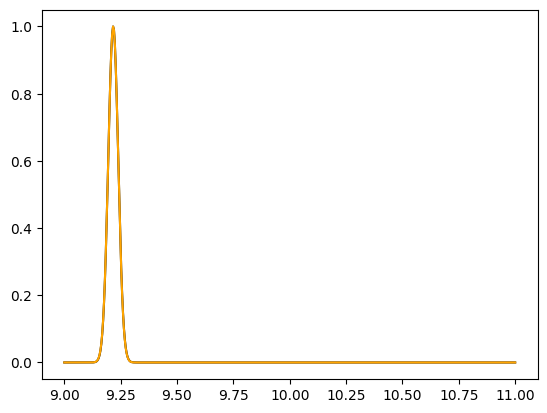

In [357]:
ds = np.linspace(9, 11, 500)
logprs_l = np.zeros_like(ds)
logprs_ll = np.zeros_like(ds)
for i, d in enumerate(ds):
    logprs_l[i] = logPr_ls(y, linear, mean_X, d, sigma_l)
    logprs_ll[i] = logPr_laplace(d, logPmax_l, theta_l, H_l[0][0])
plt.plot(ds, np.exp(logprs_l-logprs_l.max()), color='black')
plt.plot(ds, np.exp(logprs_ll-logprs_ll.max()), color='orange')

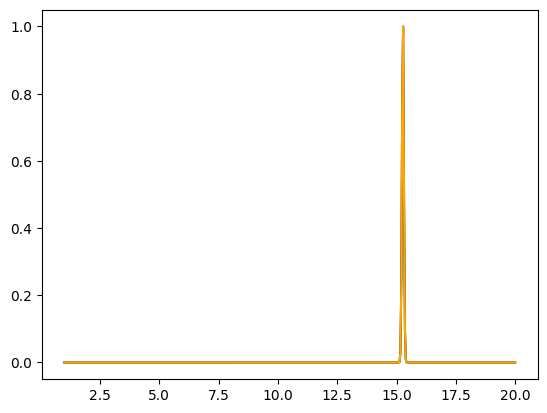

In [358]:
theta_b = minimise_bayes(y, linear, mean_X, covinv_X, theta_true).x
logPmax_b = logPr_bayes_full(y, linear, mean_X, covinv_X, theta_b, prefactor_b)
H_b = hess_bayes(y, linear_torch, mean_X, covinv_X, theta_b)
ds = np.linspace(1, 20, 500)
logprs_b = np.zeros_like(ds)
logprs_bl = np.zeros_like(ds)
for i, d in enumerate(ds):
    logprs_b[i] = logPr_bayes_full(y, linear, mean_X, covinv_X, d, prefactor_b)
    logprs_bl[i] = logPr_laplace(d, logPmax_b, theta_b, H_b)
plt.plot(ds, np.exp(logprs_b-logprs_b.max()), color='black')
plt.plot(ds, np.exp(logprs_bl-logprs_bl.max()), color='orange')

In [360]:
logZ(logPmax_b, H_b, D=1)

-47389.54721025664 -3.2341604538221427


-47391.86243217726

In [361]:
Xstar = linear.inverse(y, theta_b)
- 1/2 * (Xstar - mean_X).T @ covinv_X @ (Xstar - mean_X)

-51879.32119612002

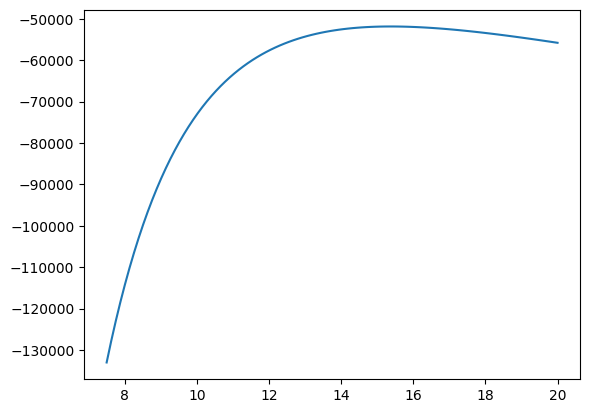

In [362]:
ds = np.linspace(7.5, 20, 100)
loss = np.zeros_like(ds)
for i, d in enumerate(ds):
    Xstar = linear.inverse(y, d)
    loss[i] = - 1/2 * (Xstar - mean_X).T @ covinv_X @ (Xstar - mean_X)
plt.plot(ds, loss)

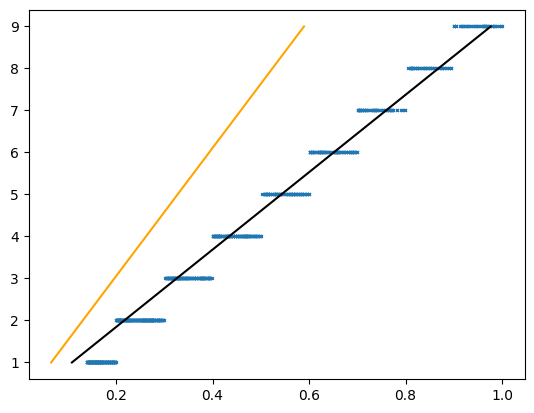

In [364]:
plt.plot(X, y, 'x', ms=2)
plt.plot(linear.inverse(y, theta_l), y, color='black')
plt.plot(linear.inverse(y, theta_b), y, color='orange')